# CNN for rock-paper-scissors with Keras/TensorFlow (interploated)

Date: December 6 and December 31, 2018

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [74]:
DATA_FOLDER = '../thermography/data_interpolated/'

FILES = 56
TRAINING_FILES = 40
TEST_FILES = FILES - TRAINING_FILES

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [76]:
# Normalization
def scale(data):
    min_ = np.min(data)
    max_ = np.max(data)
    mean = (max_ + min_) / 2.0
    range_ = (max_ - min_) / 2.0
    data = (data - mean)/range_
    return data

In [77]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #training_set.append((pp.scale(data), class_number))
            training_set.append((scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #test_set.append((pp.scale(data), class_number))
            test_set.append((scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


array([[-0.83206107, -0.81679389, -0.78625954, ..., -0.86259542,
        -0.8778626 , -0.8778626 ],
       [-0.84732824, -0.83206107, -0.80152672, ..., -0.86259542,
        -0.86259542, -0.90839695],
       [-0.84732824, -0.83206107, -0.83206107, ..., -0.83206107,
        -0.86259542, -0.92366412],
       ...,
       [-0.83206107, -0.80152672, -0.78625954, ..., -0.45038168,
        -0.48091603, -0.51145038],
       [-0.80152672, -0.77099237, -0.74045802, ..., -0.45038168,
        -0.49618321, -0.51145038],
       [-0.77099237, -0.74045802, -0.70992366, ..., -0.49618321,
        -0.52671756, -0.52671756]])

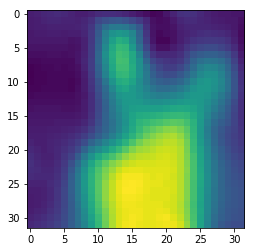

In [78]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 32, 32, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 32, 32, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,0])
train_data[12,:,:,0]

### CNN model

In [79]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1152)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3459      
Total para

In [80]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

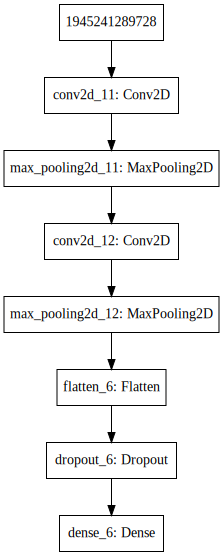

In [81]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [82]:
EPOCHS = 50
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 120 samples, validate on 48 samples
Epoch 1/50
120/120 [==============================] - 3s 21ms/step - loss: 1.0790 - acc: 0.4333 - val_loss: 1.0055 - val_acc: 0.6875
Epoch 2/50
120/120 [==============================] - 2s 15ms/step - loss: 1.0055 - acc: 0.4667 - val_loss: 0.9541 - val_acc: 0.6667
Epoch 3/50
120/120 [==============================] - 2s 15ms/step - loss: 0.9376 - acc: 0.5917 - val_loss: 0.8968 - val_acc: 0.6875
Epoch 4/50
120/120 [==============================] - 2s 14ms/step - loss: 0.9139 - acc: 0.6333 - val_loss: 0.8463 - val_acc: 0.7083
Epoch 5/50
120/120 [==============================] - 2s 16ms/step - loss: 0.8327 - acc: 0.6333 - val_loss: 0.8036 - val_acc: 0.6667
Epoch 6/50
120/120 [==============================] - 2s 17ms/step - loss: 0.7909 - acc: 0.6667 - val_loss: 0.7800 - val_acc: 0.7083
Epoch 7/50
120/120 [==============================] - 2s 18ms/step - loss: 0.7597 - acc: 0.6750 - val_loss: 0.7588 - val_acc: 0.6875
Epoch 8/50
120/120 [====

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


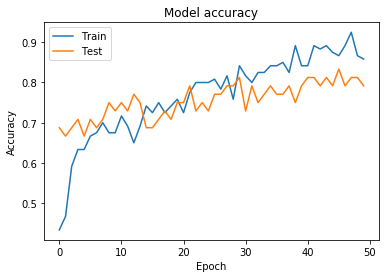

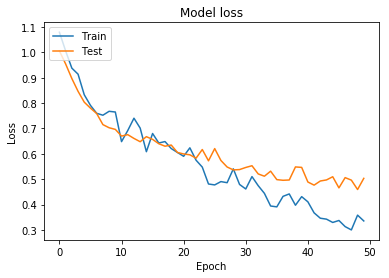

In [83]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [84]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_rock_paper_scissors_interpolated{}.h5'.format(dt)
model.save(filename)

## Load the model

In [85]:
del model
model = models.load_model(filename)

## Confirmation

In [86]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(120, 32, 32, 1)

In [87]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [88]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [89]:
class_labels

['paper', 'rock', 'scissors']

In [90]:
(activations[-1][:10]*100).astype(int)

array([[82,  4, 12],
       [ 0,  0, 99],
       [10,  6, 82],
       [94,  0,  4],
       [ 8, 42, 48],
       [77, 20,  1],
       [92,  2,  5],
       [50,  1, 47],
       [10,  9, 79],
       [57,  1, 40]])

In [91]:
test_labels[:10].astype(int)

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]])

In [92]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'scissors'

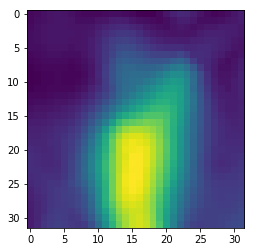

In [93]:
image_number = 10

plt.imshow(test_data[image_number,:,:,0])
class_labels[np.argmax(test_labels[image_number])]

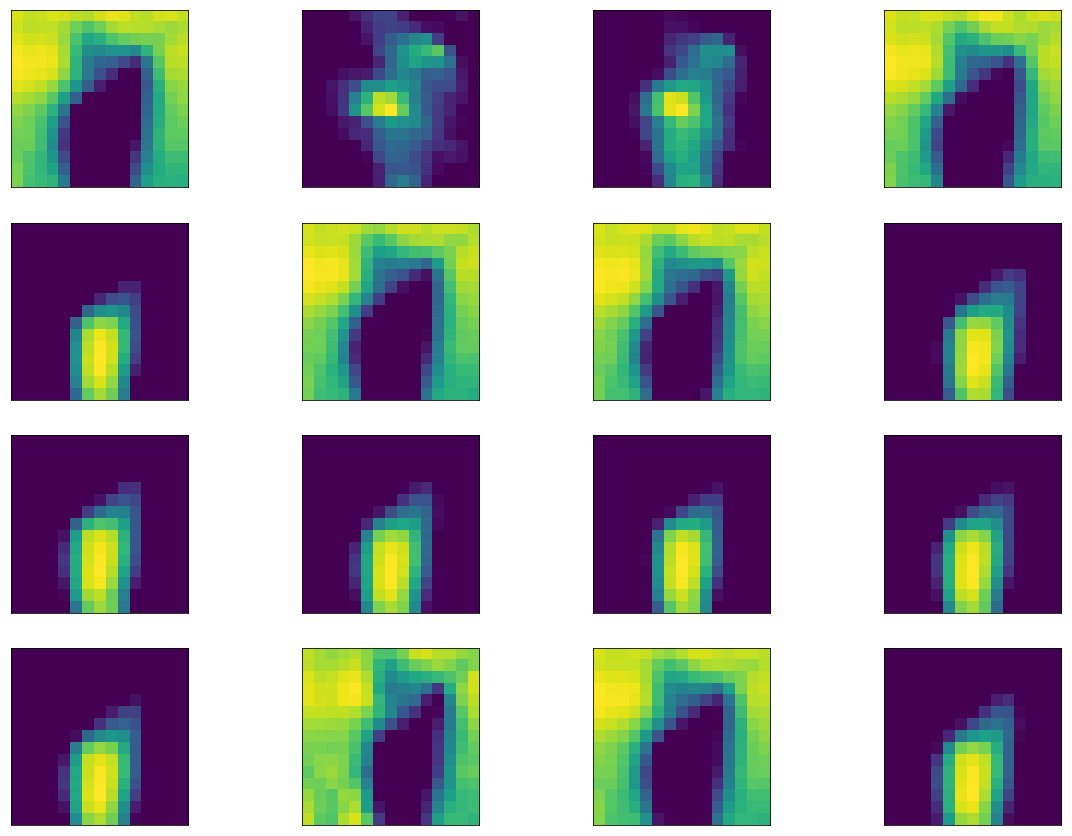

In [94]:
plot_layer(activations, image_number, 1)

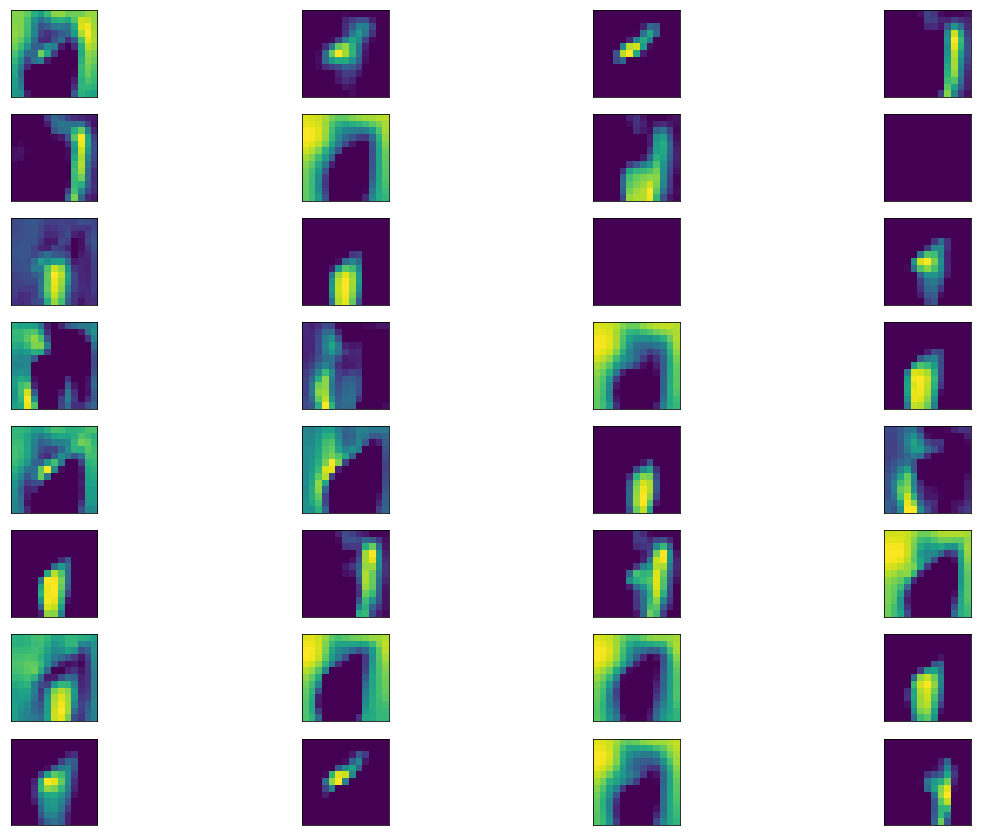

In [95]:
plot_layer(activations, image_number, 2)

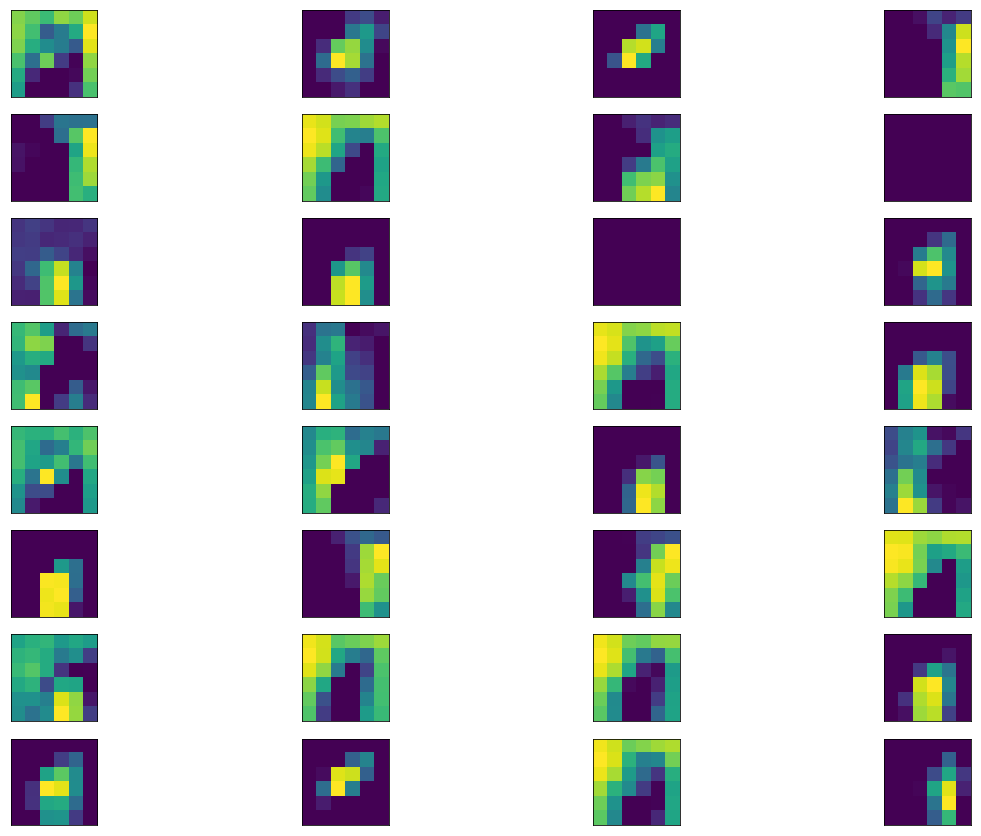

In [96]:
plot_layer(activations, image_number, 3)